#Functions and imports

**Installing dependencies**

*Run these cells if this is the first time that this notebook is being executed.*

In [5]:
#!pip install gplearn

In [6]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from gplearn.genetic import SymbolicRegressor
from sklearn.multioutput import MultiOutputRegressor
from gplearn.functions import make_function
from sympy import *

np.random.seed(100)

#Error eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats

#Synchronization model
import networkx as nx

#Extra optimizer
from sklearn.linear_model import OrthogonalMatchingPursuit

#Danger zone:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##Definitions

In [7]:
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

All structures below are quite similar, but we need to have a cell for each dynamics to take the equations into consideration correctly.

In [8]:
def volterra(t, y, a=2, b=0.5, c=1, d=0.375):
  u,v = y
  dudt = a*u - b*u*v
  dvdt = -c*v + d*b*u*v

  return [dudt, dvdt]

In [9]:
def pendulum(t, y):
    theta, omega = y
    g = 9.81  # aceleração da gravidade
    L = 1.0   # comprimento do pêndulo
    alpha = 0.1  # coeficiente de amortecimento

    d_theta = omega
    d_omega = - (g / L) * np.sin(theta) #- alpha * omega

    return [d_theta, d_omega]

In [10]:
def lorenz(t, ivp_sol, sigma=2.0, rho=1.0, beta=2.6):
  x, y, z = ivp_sol
  dx_dt = sigma * (y - x)
  dy_dt = x * (rho - z) - y
  dz_dt = x * y - beta * z

  return [dx_dt, dy_dt, dz_dt]

In [11]:
#=== SIS ===
def sis(t, y, beta = 0.3, gamma = 0.1):
  S, I = y
  dSdt = -beta * S * I + gamma * I
  dIdt = beta * S * I - gamma * I
  return [dSdt, dIdt]

In [12]:
#=== SIR ===
def sir(t, y, beta=0.3, gamma=0.1):
  S, I, R = y
  dSdt = -beta * S * I
  dIdt = beta * S * I - gamma * I
  dRdt = gamma*I
  return [dSdt, dIdt, dRdt]

In [13]:
#=== SEIR ===
def seir(t, y, beta=0.3, alpha=0.2, gamma=1.0):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

In [14]:
 #=== SEIRD ===
def seird(t, y, beta=0.3, alpha=0.2, gamma=1.0, mu=0.1):
    S, E, I, R, D = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

In [15]:
 #=== SIRV ===
def sirv(t, y, beta=0.5, gamma=1.0, nu=0.5):
    S, I, R, V = y
    dSdt = -beta * S * I - nu * S
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    dVdt = nu * S
    return [dSdt, dIdt, dRdt, dVdt]

In [16]:
 #=== SIRS ===
def sirs(t, y, beta=0.3, gamma=1.0, nu=0.2):
    S, I, R = y
    dSdt = -beta * S * I + nu * R
    dIdt =  beta * S * I - gamma * I
    dRdt = gamma * I- nu * R
    return [dSdt, dIdt, dRdt]

##Error evaluation

In [17]:
def error_eval(models, dyn_name, curves_names, targets, ivp_sol):
  '''
  This function assumes you've run one of the eval_models() functions previously
  to estimate y_true and y_pred to keep it compatible with all dynamics.
  '''

  #Metrics
  mse = []
  mae = []
  r2 = []
  rmse = []
  y_preds = []

  #Predict for each model found
  for n in list(range(len(models))):
    y_preds.append(models[n].predict(ivp_sol.y.T))

  #y_int = model.predict(init_params)
  len_sol = ivp_sol.y.T.shape[1]

  for i in range(len_sol):
    mse.append(mean_squared_error(y_preds[i], targets[i]))
    mae.append(mean_absolute_error(y_preds[i], targets[i]))
    if (r2_score(y_preds[i], targets[i]) < 0):
      r2.append(0)
    else:
      r2.append(r2_score(y_preds[i], targets[i]))
    rmse.append(np.sqrt(mean_squared_error(y_preds[i], targets[i])))

  res = pd.DataFrame(data={'dynamics': np.repeat(dyn_name,len_sol), 'axis': curves_names,
                           'mae': mae, 'mse': mse, 'r2': r2, 'rmse':rmse})

  return res

#Dynamics to investigate

##Lorenz

In [ ]:
#Parameters
feature_names = ['X', 'Y', 'Z']
t_start = 0.0
t_end = 5.0
t_step = 0.02
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

x0, y0, z0 = 0.6, 2.0, 1.0  # Condições iniciais
state0 = [x0, y0, z0]

In [ ]:
#Solve the system
solution = solve_ivp(lorenz, t_span, state0, method='RK45', t_eval=t_eval)
solution_df = pd.DataFrame(solution.y.T, columns=feature_names)

#Target variables
dxdt = lorenz([0], solution.y)[0]
dydt = lorenz([0], solution.y)[1]
dzdt = lorenz([0], solution.y)[2]
targets = np.column_stack((dxdt,dydt,dzdt))

In [ ]:
#Fit the model
est_gp = MultiOutputRegressor(SymbolicRegressor(population_size=10000,
                            generations=100,
                            tournament_size=100,
                            stopping_criteria=0.01,
                            p_crossover=0.6,
                            p_subtree_mutation=0.2,
                            p_hoist_mutation=0.01,
                            p_point_mutation=0.09,
                            verbose=1,
                            init_depth=(6, 10),
                            parsimony_coefficient=0.001,
                            function_set=['mul', 'sub','add'],
                            random_state=0))
est_gp.fit(np.column_stack((solution_df.values)), targets)

In [ ]:
expressions = est_gp.estimators_

#Print the obtained expressions
for i, est in enumerate(expressions):
    print(f"Output {i+1}:")
    print(est._program)
    print()

Output 1:
add(sub(X1, X0), sub(X1, X0))
Output 2:
sub(sub(X0, mul(X0, X2)), X1)
Output 3:
sub(mul(X1, 0.193), X2)


In [ ]:
res = error_eval(expressions, 'Lorenz', feature_names, targets=targets,ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse
0,Lorenz,X,0.000825,0.000002,0.999991,0.001405
1,Lorenz,Y,0.000559,0.000002,0.999990,0.001376
2,Lorenz,Z,0.032195,0.007783,0.793979,0.088221


##Lotka-Volterra

In [ ]:
#Parameters
feature_names = ['u', 'v']

t_start = 0.0
t_end = 7.5
t_step = 0.1
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

state0 = np.array([20, 5])

In [ ]:
#Solve the system
solution = solve_ivp(volterra, t_span, state0, t_eval=t_eval)
solution_df = pd.DataFrame(solution.y.T, columns=feature_names)

#Target variables
dudt = volterra([0], solution.y)[0]
dvdt = volterra([0], solution.y)[1]
targets = np.column_stack((dudt,dvdt))

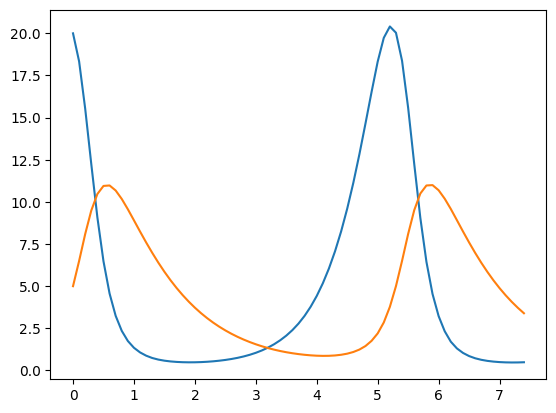

In [ ]:
plt.plot(t_eval,solution.y[0])
plt.plot(t_eval,solution.y[1])

In [ ]:
est_gp = MultiOutputRegressor(SymbolicRegressor(population_size=5000,
                                                generations=50,
                                                tournament_size=50,
                                                p_crossover=0.6,
                                                p_subtree_mutation=0.2,
                                                p_hoist_mutation=0.01,
                                                p_point_mutation=0.09,
                                                verbose=1,
                                                init_depth=(3, 5),    #(8, 9)
                                                parsimony_coefficient=0.001,
                                                function_set=['sub','mul', 'add'],
                                                random_state=0))
est_gp.fit(np.column_stack((solution_df.values)), targets)

In [ ]:
expressions = est_gp.estimators_

#Print the obtained expressions
for i, est in enumerate(expressions):
    print(f"Output {i+1}:")
    print(est._program)
    print()

Output 1:
add(add(mul(mul(X1, X0), -0.493), X0), X0)
Output 2:
sub(mul(0.373, mul(X0, X1)), X1)


In [ ]:
res = error_eval(models, 'Lotka-Volterra', feature_names, targets=targets,ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse
0,Lotka-Volterra,u,0.396083,4.17,0.982515,2.041226
1,Lotka-Volterra,v,0.540048,3.84,0.980838,1.959725


##Simple pendulum

In [ ]:
#Parameters
feature_names = ['theta', 'omega']

t_start = 0.0
t_end = 10
t_step = 0.01
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

state0 = np.array([np.radians(45), 0])

In [ ]:
#Solve the system
solution = solve_ivp(pendulum, t_span, state0, t_eval=t_eval)
solution_df = pd.DataFrame(solution.y.T, columns=feature_names)

#Target variables
dthetadt = pendulum([0], solution.y)[0]
domegadt = pendulum([0], solution.y)[1]
targets = np.column_stack((dthetadt,domegadt))

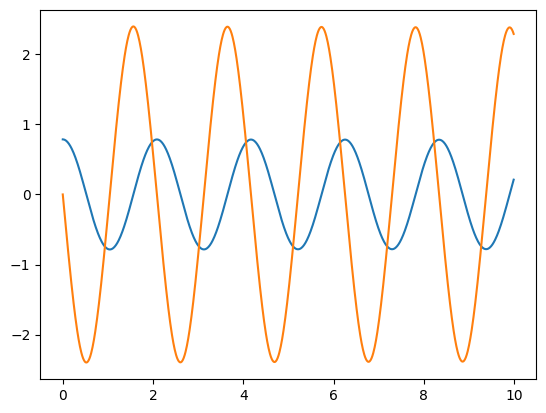

In [ ]:
plt.plot(t_eval,solution.y[0])
plt.plot(t_eval,solution.y[1])

In [ ]:
est_gp = MultiOutputRegressor(SymbolicRegressor(population_size=5000,
                           generations=100,
                           tournament_size=100,
                           p_crossover=0.7,
                           p_subtree_mutation=0.2,
                           p_hoist_mutation=0.01,
                           p_point_mutation=0.09,
                           verbose=1,
                           init_depth=(2, 2),
                           parsimony_coefficient=0.009,
                           function_set=['sub', 'mul', 'div', 'sin'],
                           random_state=0))
est_gp.fit(np.column_stack((solution_df.values)), targets)

In [ ]:
expressions = est_gp.estimators_

#Print the obtained expressions
for i, est in enumerate(expressions):
    print(f"Output {i+1}:")
    print(est._program)
    print()

Output 1:
X1
Output 2:
div(sin(div(X0, 0.921)), -0.109)


In [ ]:
res = error_eval(models, 'Pendulum', feature_names, targets=targets,ivp_sol=solution)
res

,dynamics,axis,mae,mse,r2,rmse
0,Pendulum,theta,0.001402,0.000004,0.999999,0.002023
1,Pendulum,omega,0.023827,0.000739,0.999971,0.027188


##SIR

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.002
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0 = 0.001, 0.0
S0 = N - I0 - R0
x0 = np.array([S0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1

In [ ]:
#Solve the SIR system
solution = solve_ivp(sir, t_span, x0, t_eval=t_eval)
solution_df = pd.DataFrame(solution.y.T, columns=feature_names)

#Target variables
dSdt = sir([0], solution.y)[0]
dIdt = sir([0], solution.y)[1]
dRdt = sir([0], solution.y)[2]
targets = np.column_stack((dSdt,dIdt,dRdt))

In [ ]:
est_gp = MultiOutputRegressor(SymbolicRegressor(population_size=10000,
                                                generations=100,
                                                tournament_size=100,
                                                stopping_criteria=0.01,
                                                p_crossover=0.7,
                                                p_subtree_mutation=0.1,
                                                p_hoist_mutation=0.05,
                                                p_point_mutation=0.1,
                                                max_samples=0.9,
                                                init_depth=(3, 6),
                                                verbose=1,
                                                parsimony_coefficient=0.7,
                                                function_set=['mul', 'add'],
                                                random_state=0))
est_gp.fit(np.column_stack((solution_df.values)), targets)

In [ ]:
expressions = est_gp.estimators_

#Print the obtained expressions
for i, est in enumerate(expressions):
    print(f"Output {i+1}:")
    print(est._program)
    print()

Output 1:
mul(mul(X1, mul(X0, -0.973)), 0.300)
Output 2:
mul(X1, mul(mul(add(0.651, -0.910), add(X0, -0.348)), -0.976))
Output 3:
mul(X1, 0.101)


In [19]:
res = error_eval('SIR', feature_names, y_preds=y_preds,targets=targets)
res

,dynamics,axis,mae,mse,r2,rmse
0,Lorenz,X,0.018480,0.000977,0.000000,0.031257
1,Lorenz,Y,0.007368,0.000127,0.000000,0.011261
2,Lorenz,Z,0.000094,0.000000,0.999814,0.000136


##SIS

In [ ]:
#Parameters
feature_names = ['S', 'I']
#Time
t = np.linspace(0, 10, 100)
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

#SIS
N = 1
I0 = 0.001
S0 = N - I0
x0 = np.array([S0, I0])

In [ ]:
#Solve the SIS system
solution = solve_ivp(sis, t_span, x0, t_eval=t_eval)
solution_df = pd.DataFrame(solution.y.T, columns=feature_names)

#Target variables
dSdt = sis([0], solution.y)[0]
dIdt = sis([0], solution.y)[1]
targets = np.column_stack((dSdt,dIdt))

In [ ]:
est_gp = MultiOutputRegressor(SymbolicRegressor(population_size=650,
                                                generations=150,
                                                tournament_size=150,
                                                stopping_criteria=0.01,
                                                p_crossover=0.7,
                                                p_subtree_mutation=0.1,
                                                p_hoist_mutation=0.1,
                                                p_point_mutation=0.1,
                                                verbose=0,
                                                function_set=['add', 'mul'],
                                                parsimony_coefficient=0.01,
                                                random_state=0))
est_gp.fit(np.column_stack((solution_df.values)), targets)

In [ ]:
expressions = est_gp.estimators_

#Print the obtained expressions
for i, est in enumerate(expressions):
    print(f"Output {i+1}:")
    print(est._program)
    print()

Output 1:
add(X1, mul(mul(X1, mul(mul(X1, -0.281), add(0.886, X0))), X0))
Output 2:
add(mul(add(X1, X0), add(mul(-0.189, X1), mul(-0.767, X1))), mul(mul(X0, -0.067), mul(X1, -0.854)))


In [ ]:
res = error_eval(models, 'SIS', feature_names, targets=targets,ivp_sol=solution)
res.drop(columns=['mse', 'rmse'], inplace=True)
res

,dynamics,axis,mae,r2
0,SIS,S,0.008822,0.997984
1,SIS,I,0.009030,0.997071


## Semi-supervised approaches

GPLearn does not converge to solutions that are close to the real compartimental models when considering more than three compartments (or reinfection). With that in mind, the next few sections employ a semi-supervised method to find the best fits.

In [ ]:
def error_eval(dyn_name, curves_names, y_preds, targets):
  '''
  This function assumes you've run one of the eval_models() functions previously
  to estimate y_true and y_pred to keep it compatible with all dynamics.
  '''

  #Metrics
  mse = []
  mae = []
  r2 = []
  rmse = []
  len_sol = len(y_preds)

  for i in range(len_sol):
    mse.append(mean_squared_error(y_preds[i], targets[i]))
    mae.append(mean_absolute_error(y_preds[i], targets[i]))
    r2.append(r2_score(y_preds[i], targets[i]))
    rmse.append(np.sqrt(mean_squared_error(y_preds[i], targets[i])))


  res = pd.DataFrame(data={'dynamics': np.repeat(dyn_name,len_sol), 'axis': curves_names,
                           'mae': mae, 'mse': mse, 'r2': r2, 'rmse':rmse})

  return res

###SEIR

In [ ]:
#Parameters
feature_names = ['S', 'E', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, E0 = 0.001, 0.0, 0.0
S0 = N - I0 - R0 - E0
x0 = np.array([S0, E0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta = 0.3
gamma = 1.0
alpha = 0.2

In [ ]:
#Solve the SEIR system
solution = solve_ivp(seir, t_span, x0, t_eval=t_eval, args=(0.3, 0.2, 1.0))
solution_df = pd.DataFrame(solution.y.T, columns=feature_names)

#Target variables
dSdt = seir([0], solution.y)[0]
dEdt = seir([0], solution.y)[1]
dIdt = seir([0], solution.y)[2]
dRdt = seir([0], solution.y)[3]

Susceptible

In [ ]:
targets = np.column_stack((solution_df['S'].values,solution_df['I'].values))

est_gpS = SymbolicRegressor(population_size=1000,
                            generations=2000,
                            tournament_size=2000,
                            stopping_criteria=0.01,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.05,
                            p_point_mutation=0.1,
                            max_samples=0.9,
                            init_depth=(2, 5),
                            verbose=1,
                            parsimony_coefficient=0.05,
                            random_state=0)

est_gpS.fit(targets, dIdt)

print(f"Best expression: {est_gpS._program}")

Best expression: mul(div(0.272, -0.951), mul(X0, X1))


Exposed

In [ ]:
targets = np.column_stack((solution_df['S'].values,solution_df['E'].values,solution_df['I'].values))

function_set = ['add', 'sub', 'mul']
est_gpE = SymbolicRegressor(population_size=50000,
                            generations=5000,
                            tournament_size=5000,
                            stopping_criteria=0.001,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.05,
                            p_point_mutation=0.1,
                            init_method='grow',
                            max_samples=0.9,
                            verbose=1,
                            init_depth=(2, 4),
                            parsimony_coefficient=0.01,
                            random_state=0,
                            function_set=['sub', 'mul'] )

est_gpE.fit(targets, dEdt)
print(f"Best expression: {est_gpE._program}")

Best expression: mul(X0, mul(sub(mul(-0.406, X2), sub(X2, X1)), mul(-0.279, 0.702)))


Infected

In [ ]:
targets = np.column_stack((solution_df['E'].values,solution_df['I'].values))

est_gpI = SymbolicRegressor(population_size=10000,
                           generations=2000,
                            tournament_size=2000,
                            stopping_criteria=0.0001,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.05,
                            p_point_mutation=0.1,
                            max_samples=0.9,
                            init_depth=(0, 5),
                            verbose=1,
                            parsimony_coefficient=0.7,
                            function_set = [ 'mul', 'sub'],
                            random_state=0)

est_gpI.fit(targets, dIdt)
print(f"Best expression: {est_gpI._program}")

Best expression: sub(mul(X0, -0.795), sub(X1, X0))


Recovered

In [ ]:
targets = np.column_stack((solution_df['S'].values,solution_df['I'].values))

est_gpR = SymbolicRegressor(population_size=1000,
                            generations=2000,
                            tournament_size=2000,
                            stopping_criteria=0.01,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.05,
                            p_point_mutation=0.1,
                            max_samples=0.9,
                            init_depth=(0, 5),
                            verbose=1,
                            parsimony_coefficient=0.05,
                            function_set = ['neg', 'mul'],
                            random_state=0)

est_gpR.fit(targets, dRdt)
print(f"Best expression: {est_gpR._program}")

neg(neg(X0))


In [ ]:
#S: solution.y[0]
#E: solution.y[1]
#I: solution.y[2]
#R: solution.y[3]

dSdt_preds = -0.286014721345952*solution.y[2] * solution.y[0]
dEdt_preds = solution.y[0]*(-0.195858*solution.y[1]+0.275376348*solution.y[2])
dIdt_preds = 0.205*solution.y[1]-solution.y[2]
dRdt_preds = solution.y[2]

y_preds = [dSdt_pred,dEdt_pred,dIdt_pred,dRdt_pred]

In [ ]:
res = error_eval('SEIR', feature_names, y_preds=y_preds, targets=np.column_stack((dSdt,dEdt,dIdt,dRdt)))
res.drop(columns=['mse', 'rmse'], inplace=True)
res

,dynamics,axis,mae,r2
0,SEIR,S,2.090000e-07,0.997740
1,SEIR,E,2.750000e-07,0.992285
2,SEIR,I,1.070000e-07,0.999986
3,SEIR,R,0.000000e+00,1.000000


###SEIRD

In [ ]:
#Parameters
feature_names = ['S', 'E', 'I', 'R', 'D']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1   #why does it changes here?
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, E0, D0 = 0.001, 0.0, 0.0, 0.0
S0 = N - I0 - R0 - E0 - D0
x0 = np.array([S0, E0, I0, R0, D0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta = 0.3
gamma = 1.0
alpha = 0.2
mu = 0.1

In [ ]:
#Solve the SEIR system
solution = solve_ivp(seird, t_span, x0, t_eval=t_eval, args=(0.3, 0.2, 1.0, 0.1))
solution_df = pd.DataFrame(solution.y.T, columns=feature_names)

#Target variables
dSdt = seird([0], solution.y)[0]
dEdt = seird([0], solution.y)[1]
dIdt = seird([0], solution.y)[2]
dRdt = seird([0], solution.y)[3]
dDdt = seird([0], solution.y)[3]

Susceptible

In [ ]:
targets = np.column_stack((solution_df['S'].values,solution_df['I'].values))

est_gpS = SymbolicRegressor(population_size=1000,
                            generations=100,
                            tournament_size=100,
                            stopping_criteria=0.001,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.05,
                            p_point_mutation=0.1,
                            max_samples=0.9,
                            init_depth=(2, 2),
                            verbose=1,
                            parsimony_coefficient=0.05,
                            function_set=['mul', 'sub'],
                            random_state=0)

est_gpS.fit(targets, dIdt)

print(f"Best expression: {est_gpS._program}")

Best expression: mul(mul(X1, X0), -0.300)


Exposed

In [ ]:
targets = np.column_stack((solution_df['S'].values,solution_df['E'].values,solution_df['I'].values))

function_set = ['add', 'sub', 'mul']
est_gpE = SymbolicRegressor(population_size=60000,
                            generations=6000,
                            tournament_size=6000,
                            stopping_criteria=0.0001,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.05,
                            p_point_mutation=0.1,
                            init_method='full',
                            verbose=1,
                            init_depth=(3, 4),
                            parsimony_coefficient=0.01,
                            random_state=0,
                            function_set=['sub', 'mul'] )

est_gpE.fit(targets, dEdt)
print(f"Best expression: {est_gpE._program}")

−0.188X0*X1−0.306X2(−X0+X1)

Infected

In [ ]:
targets = np.column_stack((solution_df['E'].values,solution_df['I'].values))

est_gpI = SymbolicRegressor(population_size=10000,
                           generations=2000,
                            tournament_size=2000,
                            stopping_criteria=0.0001,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.05,
                            p_point_mutation=0.1,
                            max_samples=0.9,
                            init_depth=(0, 5),
                            verbose=1,
                            parsimony_coefficient=0.7,
                            function_set = ['mul', 'sub'],
                            random_state=0)

est_gpI.fit(targets, dIdt)
print(f"Best expression: {est_gpI._program}")

Best expression: sub(mul(X0, -0.823), sub(X1, X0))


Recovered

In [ ]:
targets = np.column_stack((solution_df['I'].values))

est_gpR = SymbolicRegressor(population_size=5000,
                            generations=200,
                            tournament_size=200,
                            stopping_criteria=0.00000000000001,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.1,
                            p_point_mutation=0.1,
                            max_samples=0.9,
                            init_depth=(1, 2),
                            verbose=1,
                            parsimony_coefficient=0.1,
                            function_set = ['sub', 'mul'],
                            random_state=0)

est_gpR.fit(targets, dRdt)
print(f"Best expression: {est_gpR._program}")

Best expression: mul(mul(X0, 0.094), mul(0.346, X0))


Deceased

In [ ]:
targets = np.column_stack((solution_df['I'].values))

est_gpD = SymbolicRegressor(population_size=5000,
                            generations=200,
                            tournament_size=200,
                            stopping_criteria=0.00000000000001,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.1,
                            p_point_mutation=0.1,
                            max_samples=0.9,
                            init_depth=(1, 2),
                            verbose=1,
                            parsimony_coefficient=0.1,
                            function_set = ['sub', 'mul'],
                            random_state=0)

est_gpD.fit(targets, dDdt)
print(f"Best expression: {est_gpD._program}")

Best expression: mul(mul(X0, 0.094), mul(0.346, X0))


In [ ]:
#S: solution.y[0]
#E: solution.y[1]
#I: solution.y[2]
#R: solution.y[3]
#D: solution.y[4]

dSdt_preds = -0.3*solution.y[0]*solution.y[2]
dEdt_preds = -0.188*solution.y[0]*solution.y[1]-0.306*solution.y[2]*(-solution.y[0]+solution.y[1])
dIdt_preds = 0.177*solution.y[1]-solution.y[2]
dRdt_preds = 0.09*solution.y[2]
dDdt_preds = 0.09*solution.y[2]

y_preds = [dSdt_pred,dEdt_pred,dIdt_pred,dRdt_pred,dDdt_pred]

In [ ]:
res = error_eval('SEIRD', feature_names, y_preds=y_preds, targets=np.column_stack((dSdt,dEdt,dIdt,dRdt,dDdt)))
res.drop(columns=['mse', 'rmse'], inplace=True)
res

,dynamics,axis,mae,r2
0,SEIRD,S,7.060000e-19,1.000000
1,SEIRD,E,3.060000e-07,0.998062
2,SEIRD,I,9.410000e-07,0.991746
3,SEIRD,R,0.000000e+00,1.000000
4,SEIRD,D,1.320000e-07,0.989660


###SIRV

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R', 'V']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, V0 = 0.001, 0.0, 0.5
S0 = N - I0 - R0 - V0
x0 = np.array([S0, I0, R0, V0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1
nu=0.5

In [ ]:
#Solve the SIR system
solution = solve_ivp(sirv, t_span, x0, t_eval=t_eval)
solution_df = pd.DataFrame(solution.y.T, columns=feature_names)

#Target variables
dSdt = sirv([0], solution.y)[0]
dIdt = sirv([0], solution.y)[1]
dRdt = sirv([0], solution.y)[2]
dVdt = sirv([0], solution.y)[3]

Susceptible

In [ ]:
targets = np.column_stack((solution_df['S'].values,solution_df['R'].values))

est_gpS = SymbolicRegressor(population_size=2000,
                           generations=350,
                           tournament_size=350,
                           stopping_criteria=0.01,
                           p_crossover=0.7,
                           p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1,
                           p_point_mutation=0.1,
                           init_depth = (2,4),
                           verbose=0,
                           function_set=['sub', 'mul'],
                           parsimony_coefficient=0.01,
                           random_state=0)
est_gpS.fit(targets, dSdt)
print(f"Best expression: {est_gpS._program}")

Best expression: mul(X0, sub(-0.495, X1))


Infected

In [ ]:
targets = np.column_stack((solution_df['S'].values,solution_df['I'].values))

est_gpI = SymbolicRegressor(population_size=6500,
                           generations=500,
                           tournament_size=150,
                           stopping_criteria=0.01,
                           p_crossover=0.7,
                           p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05,
                           p_point_mutation=0.1,
                           init_method='grow',
                           max_samples=0.9,
                           verbose=1,
                           init_depth=(3, 3),
                           parsimony_coefficient=0.01,
                           random_state=0,
                           function_set=['sub', 'mul'] )

est_gpI.fit(targets, dIdt)
print(f"Best expression: {est_gpI._program}")

Best expression: mul(X1, sub(-0.895, mul(-0.423, X0)))


Recovered

In [ ]:
targets = np.column_stack((solution_df['I'].values,solution_df['R'].values))

est_gpR = SymbolicRegressor(population_size=2000,
                            generations=350,
                            tournament_size=350,
                            stopping_criteria=0.01,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.1,
                            p_point_mutation=0.1,
                            init_depth = (2,4),
                            verbose=0,
                            function_set=['sub', 'mul'],
                            parsimony_coefficient=0.01,
                            random_state=0)

est_gpR.fit(targets, dRdt)
print(f"Best expression: {est_gpR._program}")

Best expression: sub(X0, sub(X0, X0))


Vaccinated

In [ ]:
targets = np.column_stack((solution_df['S'].values))

est_gpV = SymbolicRegressor(population_size=2000,
                             generations=350,
                             tournament_size=350,
                             stopping_criteria=0.01,
                             p_crossover=0.7,
                             p_subtree_mutation=0.1,
                             p_hoist_mutation=0.1,
                             p_point_mutation=0.1,
                             verbose=0,
                             function_set=['add', 'mul'],
                             parsimony_coefficient=0.01,
                             random_state=0)

est_gpV.fit(targets, dVdt)
print(f"Best expression: {eest_gpV._program}")

Best expression: add(mul(0.267, X0), mul(X0, 0.216))


In [ ]:
#S: solution.y[0]
#I: solution.y[1]
#R: solution.y[2]
#V: solution.y[3]

dSdt_preds = -solution.y[0]*solution.y[1]-solution.y[0]*0.495
dIdt_preds = 0.423*solution.y[0]*solution.y[1]-0.895*solution.y[1]
dRdt_preds = solution.y[1]
dVdt_preds = 0.483*solution.y[0]

y_preds = [dSdt_pred,dIdt_pred,dRdt_pred,dVdt_pred]

In [ ]:
res = error_eval('SIRV', feature_names, y_preds=y_preds, targets=np.column_stack((dSdt,dIdt,dRdt,dVdt)))
res.drop(columns=['mse', 'rmse'], inplace=True)
res

,dynamics,axis,mae,r2
0,SIRV,S,9.660000e-05,0.999909
1,SIRV,I,8.890000e-07,0.993616
2,SIRV,R,0.000000e+00,1.000000
3,SIRV,V,3.437981e-04,0.998796


###SIRS

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0 = 0.001, 0.0
S0 = N - I0 - R0
x0 = np.array([S0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1

In [ ]:
#Solve the SIRS system
solution = solve_ivp(sirs, t_span, x0, t_eval=t_eval)
solution_df = pd.DataFrame(solution.y.T, columns=feature_names)

#Target variables
dSdt = sirs([0], solution.y)[0]
dIdt = sirs([0], solution.y)[1]
dRdt = sirs([0], solution.y)[2]

Susceptible

In [ ]:
targets = np.column_stack((solution_df['S'].values,solution_df['I'].values,solution_df['R'].values))

est_gpS = SymbolicRegressor(population_size=10000,
                           generations=500,
                           tournament_size=500,
                           stopping_criteria=0.01,
                           p_crossover=0.7,
                           p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1,
                           p_point_mutation=0.1,
                           init_depth = (3,4),
                           verbose=0,
                           function_set=['sub', 'mul', 'neg'],
                           parsimony_coefficient=0.01,
                           random_state=0)
est_gpS.fit(targets, dSdt)
print(f"Best expression: {est_gpS._program}")

Best expression: sub(sub(mul(X1, -0.205), mul(X1, X2)), neg(mul(0.185, X2)))


Infected

In [ ]:
targets = np.column_stack((solution_df['S'].values,solution_df['I'].values))

est_gpI = SymbolicRegressor(population_size=80000,
                           generations=1000,
                           tournament_size=1000,
                           stopping_criteria=0.01,
                           p_crossover=0.7,
                           p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1,
                           p_point_mutation=0.1,
                           verbose=0,
                           init_depth=(3, 3),
                           parsimony_coefficient=0.01,
                           random_state=0,
                           function_set=['sub', 'mul'] )

est_gpI.fit(targets, dIdt)
print(f"Best expression: {est_gpI._program}")

Best expression: sub(mul(mul(-0.092, X1), mul(-0.849, 0.196)), mul(X0, mul(0.717, X1)))


Recovered

In [ ]:
targets = np.column_stack((solution_df['I'].values,solution_df['R'].values))

est_gpR = SymbolicRegressor(population_size=10000,
                            generations=600,
                            tournament_size=500,
                            stopping_criteria=0.01,
                            p_crossover=0.7,
                            p_subtree_mutation=0.1,
                            p_hoist_mutation=0.1,
                            p_point_mutation=0.1,
                            init_depth = (3,4),
                            verbose=0,
                            function_set=['sub', 'mul', 'neg'],
                            parsimony_coefficient=0.01,
                            random_state=0)

est_gpR.fit(targets, dRdt)
print(f"Best expression: {est_gpR._program}")

Best expression: neg(sub(sub(mul(0.186, X1), sub(X0, X0)), neg(neg(X0))))


In [ ]:
#S: solution.y[0]
#I: solution.y[1]
#R: solution.y[2]

dSdt_preds =  -solution.y[1]*solution.y[2] - 0.205*solution.y[1] + 0.185*solution.y[2]
dIdt_preds =  -0.717*solution.y[0]*solution.y[1]+0.015309168*solution.y[1]
dRdt_preds =  solution.y[1]-0.203*solution.y[2]

y_preds = [dSdt_pred,dIdt_pred,dRdt_pred]

In [ ]:
res = error_eval('SIRS', feature_names, y_preds=y_preds, targets=np.column_stack((dSdt,dIdt,dRdt)))
res.drop(columns=['mse', 'rmse'], inplace=True)
res

,dynamics,axis,mae,r2
0,SIRS,S,1.530000e-06,0.956507
1,SIRS,I,9.360000e-09,0.999999
2,SIRS,R,2.150000e-07,0.999939
